# Northern Hemisphere Sea Ice Extent Prediction (1979-2070)
### Written by Seongheon Park in 2022

#### Import necessary modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Import CSV and set index as date

In [2]:
df = pd.read_csv("Northern Hemisphere Sea Ice Extent (1979-2022).csv", parse_dates=["Date"])

In [3]:
df["Date"] = pd.to_datetime(df.Date, format="%Y%m")
data = df.drop(["Date"], axis=1)
data.index = df.Date

### Remove -9999s i.e. error values

In [4]:
cols = data.columns
for j in cols:
    for i in range(0, len(data)):
        if data[j][i] == -9999:
            data[j][i] = data[j][i-1]

from statsmodels.tsa.vector_ar.vecm import coint_johansen
coint_johansen(data.drop("Value", axis=1), -1, 1).eig

array([0.04064359])

### Seasonal Decompose

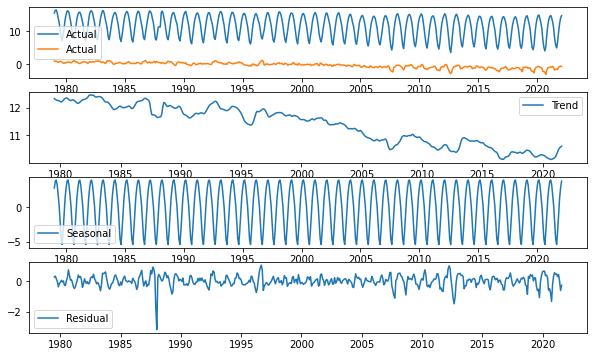

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decom=seasonal_decompose(data["Value"])
dftend=decom.trend
dfsea=decom.seasonal
dfres=decom.resid
plt.figure(figsize=(10,6))
plt.subplot (411)
plt.plot(data,label='Actual')
plt.legend()
plt.subplot (412)
plt.plot(dftend,label='Trend')
plt.legend()
plt.subplot (413)
plt.plot(dfsea,label='Seasonal')
plt.legend()
plt.subplot(414)
plt.plot(dfres, label='Residual')
plt.legend()

#### Find SARIMAX variables using auto_arima

In [6]:
from pmdarima.arima import auto_arima

model = auto_arima(data["Value"], start_p=1, start_q=1, d=1, max_p=30, max_q=30, max_d=30, m=12, start_Q=0, max_P=30, max_D=30, max_Q=30, seasonal=True, information_criterion="aic")

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  518
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -188.346
Date:                              Mon, 18 Jul 2022   AIC                            382.693
Time:                                      12:42:12   BIC                            395.437
Sample:                                           0   HQIC                           387.686
                                              - 518                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9995      0.001   1975.839      0.000       0.998       1.000
ma.S.L12      -0.8265      0.022    -37.667      0.000      -0.870      -0.784
sigma2         0.1094      0.002     59.656      0.000       0.106       0.113
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):             14656.64
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             1.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Prepare for prediction

In [7]:
size = int(len(data) * 0.75)

Xtrain, Xtest = data[0:size], data[size:]

#### Train SARIMAX model and do test

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(Xtrain["Value"], order=(0, 1, 0), seasonal_order=(1, 0, [1], 12))
result = model.fit()

testprid = pd.DataFrame(result.predict(start=len(Xtrain), end=len(data)))
testprid.columns = ['Prediction']

data = pd.concat((data, testprid), axis=1)

/Users/n30gu1/mambaforge/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/n30gu1/mambaforge/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64825D-01    |proj g|=  3.69409D-01

At iterate    5    f=  4.52514D-01    |proj g|=  9.53896D-02

At iterate   10    f=  4.52113D-01    |proj g|=  2.85136D-02

At iterate   15    f=  4.47146D-01    |proj g|=  2.86608D-01

At iterate   20    f=  4.22339D-01    |proj g|=  1.20853D-01

At iterate   25    f=  4.18530D-01    |proj g|=  8.52462D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     59      2     0     0   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


### Predict with SARIMAX

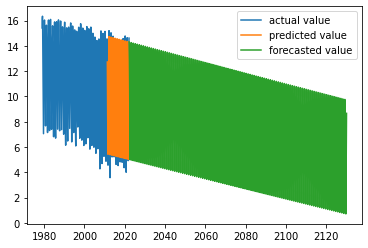

In [11]:
yhat = result.predict(start="2022-03-01", end="2070-01-01")

plt.plot(data.index, data["Value"], label="actual value")
plt.plot(data.index, data["Prediction"], label="predicted value")
plt.plot(pd.DataFrame(yhat), label="forecasted value")

plt.legend()